In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation
from sympy import symbols
import numpy.matlib
import matplotlib.colors as mcolors
import shapely as shapely
import random
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);
def getPotRegions_var2(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [float(X[i][0]-imp[i]), float(X[i][1]+imp[i])]
        Bx[i,1,:]= [float(X[i][0]+imp[i]), float(X[i][1]+imp[i])]
        Bx[i,2,:]= [float(X[i][0]+imp[i]), float(X[i][1]-imp[i])]
        Bx[i,3,:]= [float(X[i][0]-imp[i]), float(X[i][1]-imp[i])]
    return(Bx);
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;
def minOrthProj(Xi,Xj,X,f):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X)-f):
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;

def get_colors(n,f):
    colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
    for attacker in range(f):
        colors.append('r')
    return colors
def ExtractX(lst,i):
    return [item[i][0] for item in lst]
def ExtractY(lst,i):
    return [item[i][1] for item in lst]

def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY]; 
def DBCPIH(n,Xn,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);
    DBCPIH= Polygon();
    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
  
    for C in combk:
        v =[]
        comb3 = list(combinations(C,3));
        for i in range(len(comb3)):
            safePoint = 1/3*(Xn[comb3[i][0]][:]+Xn[comb3[i][1]][:]+Xn[comb3[i][2]][:]);
            v.append(safePoint)
        v_empty = True
        
        for array in v:
            if v_empty:
                temp = array
                v_empty = False
            else:
                temp= np.vstack((temp,array));
      
        idx = ConvexHull(temp)
      
        Chull  = Polygon(temp[idx.vertices][:])
        if (first and DBCPIH.is_empty):
                DBCPIH = Polygon(Chull.convex_hull);
                first = False;
        else:
            DBCPIH = DBCPIH.intersection(Chull)
           
    if DBCPIH.geom_type == 'Polygon':
        safeX,safeY = np.array(DBCPIH.exterior.xy)
        return np.array((np.mean(safeX), np.mean(safeY)))
    elif DBCPIH.geom_type == 'Point':
        try:
            safeX,safeY = [DBCPIH.x, DBCPIH.y];
        except:
            safeX,safeY = np.array((0,0))
        print(np.array((safeX,safeY)))
        return np.array((safeX,safeY)).T
def getCenterpoint(n,X,i):
    n = np.arange(n);
    combk = list(combinations(n,5));
    safeX = [];
    safeY =[];
    dp1 =[]
    first = True;
    success = True;
    safeHull = Polygon();
    for comb in combk:
        Xc= np.zeros((5,2));
        j = 0;
        for idx in comb:
            Xc[j,:] = X[idx,:];
            j+=1;
        hullk = ConvexHull(Xc);
         
        dp1 = Polygon(Xc[hullk.vertices,:]);
        if safeHull.is_empty:
            safeHull = dp1;
        try:
            safeHull = safeHull.intersection(dp1);
        except:
            print("could not compute centerpoint for ",X)
            safeHull = safeHull
            success = False
    if safeHull.geom_type == 'Polygon':
        safeX,safeY = np.array(safeHull.exterior.xy)
        if safeX == [] or safeY == []:
            safeX = 0
            safeY = 0
        return[safeX,safeY]
    elif safeHull.geom_type == 'LineString' or safeHull.geom_type == "Point":
        safepoints = np.array(shapely.get_coordinates(safeHull).tolist())
        safeX = safepoints[:,0]
        safeY = safepoints[:,1]
    elif safeHull is None:
        return [0,0]
    else:
        return [0,0]
      

In [17]:
def Intersect(a1,a2,b1,b2):
    x = (b2-b1)/(a1-a2)
    y = a1*x+b1
    return (np.array((x,y)))
    
def TukeyMedian(X):
    temp =[]
    k_levels = []
    lower_klevels = []
    upper_klevels = []
    idx = 0
    step =0
    pointies =[]
    checkpoints = []
    minX = np.abs(min(X[:,0]))
    minY = np.abs(min(X[:,1]))
    offset = max(minX,minY)
    for x in X:
        x[0] = x[0]+offset
        x[1] = x[1]+offset
    for n in range(len(X)-1):
        k_levels.append([])
        lower_klevels.append([])
        upper_klevels.append([])
    for n in range(len(X)):
        a1 = X[n][0]
        b1 = X[n][1]
        for q in range(n+1,len(X)):
            a2 =X[q][0]
            b2 = X[q][1]
            
            if not (a1 == a2 and b1 == b2):
               
                if a1 != a2:
                    point= Intersect(-a1,-a2,b1,b2)
                    k,val = vert_intersect(X,point)
                   # for z in range(k+1):
                    k_levels[k].append(point)
                    if val == -1:
                        lower_klevels[k].append(point)
                    if val ==1:
                        upper_klevels[k].append(point)
    
    for i in range(len(k_levels)):
        arr = np.array(k_levels[i])
        k_levels[i] = np.unique(arr, axis =0)
        if len(k_levels[i])>0:
            idx = i;
    empty = True
    while empty:
        empty,kverts,pointies = checkPrimal(k_levels[idx],upper_klevels[idx],lower_klevels[idx],idx)
        if idx == 2:
            checkpoints = pointies
        step = step+1
        if empty and idx != 0:
            idx = idx-1;
        if step>200:
            
            empty = False
    arr = np.array(kverts)
    kverts = np.unique(arr,axis=0)
    for v in kverts:
        v[0] = v[0]-offset
        v[1] = v[1]-offset
    for c in checkpoints:
        c[0] = c[0]-offset
        c[1] = c[1]-offset
    for x in X:
        x[0] = x[0]-offset
        x[1] = x[1]-offset
    if len(kverts)>2:
        try:
            index = ConvexHull(kverts);
            kverts=  kverts[index.vertices,:]
        except:
            index = 0
    
    return idx#,kverts,checkpoints#,upper_klevels,lower_klevels,k_levels,checkpoints
                     
def vert_intersect(X,point):
    upper = 0
    lower = 0
    k =0
    for x in X:
        a = -x[0]
        b = x[1]
        if (a*point[0]+b>point[1] and np.abs(a*point[0]+b- point[1])>.000001):
            upper= upper+1
        if (a*point[0]+b<point[1] and np.abs(a*point[0]+b- point[1])>.000001):
            lower = lower+1
    if lower<upper:
        k = lower
        return (k,-1)
    if upper<lower:
        k = upper
        return(k,1)
    if upper == lower:
        k = upper
        return(k,0)
def checkPrimal(k_levels,upper_klevels,lower_klevels,idx):
    import ipdb
    intersection_empty = True
    kverts =[]
    pointies = []
    for i in range(len(k_levels)-1):
        a1 = k_levels[i][0];
        b1 = k_levels[i][1];
        for j in range(i+1,len(k_levels)):
            a2 = k_levels[j][0];
            b2 = k_levels[j][1];
            if a1 != a2:
                m = (b1-b2)/(a1-a2)
                b = b1-m*a1
                point = np.array((m,b))
           # if a1 != a2:
            #    point = Intersect(a1,a2,b1,b2)
                pointies.append(np.array((-point[0],point[1])))
               
                lower_intersection = True
                upper_intersection = True
                for l in lower_klevels:
                    if point[1]<-l[0]*point[0]+l[1]-.00001:
                        lower_intersection = False
                for u in upper_klevels:
                    if point[1]>-u[0]*point[0]+u[1]+.00001:
                        upper_intersection = False
                if upper_intersection and lower_intersection:
                    intersection_empty = False
                    point[0] = -point[0]
                    kverts.append(point)

    return intersection_empty,kverts,pointies
    

In [86]:
def attackerTarget(X,pos):
    n = (int)(np.floor(len(X)/2))
    X = X[X[:,0].argsort()]
    left = X[0:n]
    right = X[n: ]
    for l in left:
        l_idx = np.where(left ==l)[0][0]
        for l2 in left[l_idx:,:]:
            l2_idx = np.where(left ==l)[0][0]
            if not (l ==l2).all():
                lm = (l2[1]-l[1])/(l2[0]-l[0])
                lb = l2[1]-l2[0]*lm
                if l2_idx<len(left)-1:
                    left_minus = np.vstack((left[0:l_idx],left[l_idx+1:l2_idx],left[l2_idx+1,:]))
                else:
                    left_minus = np.vstack((left[0:l_idx],left[l_idx+1:l2_idx]))
                if isFacet(lm,lb,left_minus,-1):
                    for r in right:
                        r_idx = np.where(right ==r)[0][0]
                        for r2 in right[r_idx:,:]:
                            r2_idx = np.where(right ==r2)[0][0]
                            if not (r == r2).all():
                                rm = (r2[1]-r[1])/(r2[0]-r[0])
                                rb = r2[1]-r2[0]*rm
                                if r2_idx<len(right)-1:
                                    right_minus = np.vstack((right[0:r_idx],right[r_idx+1:r2_idx],right[r2_idx+1,:]))
                                else:
                                    right_minus = np.vstack((right[0:r_idx],right[r_idx+1:r2_idx]))
                                if isFacet(rm,rb,right_minus,1):
                                    px = (rb-lb)/(lm-rm)
                                    py = rm*px+rb
                                    #if (l==np.array((7,100))).all() and (l2==np.array((20,2))).all() and (r ==np.array((56,51))).all() and (r2 ==np.array((91,83))).all():
                                    y1 = lm*(px+1)+lb
                                    y2 = rm*(px-1)+rb
                                    point =np.array((px,(y1+y2)/2)) 
                                        

    return point
def isFacet(m,b,points,LR):
    if len(points) == 0:
        return True
    else:
        facet = False
        under = 0
        for p in points:
            k = LR*np.sign(m)
            if  k*p[1] < m*p[0]+b:
                under = under+1;
        if under == len(points):
            facet = True
        return facet
    

In [93]:
X = np.array(((60,24),(56,51),(49,53),(50,16),(91,83),(7,100),(20,2)))
idx = TukeyMedian(X)
print(idx)
Xt = X[0:6]
print(Xt)
l = attackerTarget(Xt,1)
print(l)
Xnew = np.vstack((Xt,l))
print(Xnew)
idxnew = TukeyMedian(Xnew)
print(idxnew)

2
[[ 60  24]
 [ 56  51]
 [ 49  53]
 [ 50  16]
 [ 91  83]
 [  7 100]]
[53.13114754 47.36038251]
[[ 60.          24.        ]
 [ 56.          51.        ]
 [ 49.          53.        ]
 [ 50.          16.        ]
 [ 91.          83.        ]
 [  7.         100.        ]
 [ 53.13114754  47.36038251]]
2


In [74]:
n = (int)(np.floor(len(X)/2))
X = X[X[:,0].argsort()]
left = X[0:n]
right = X[n: ]
left_minus = np.vstack((left[0:1],left[2:]))
for l in left:
    l_idx = np.where(left== l)[0][0]
    print(l_idx)
for r2 in right[2:,:]:
    print(r2)
print(right)

0
1
2
[60 24]
[91 83]
[[50 16]
 [56 51]
 [60 24]
 [91 83]]


In [29]:
for x in X:
    for x2 in X:
        if (x==x2).all():
            print(x, "=" ,x2)

[60 24] = [60 24]
[56 51] = [56 51]
[49 53] = [49 53]
[50 16] = [50 16]
[91 83] = [91 83]
[  7 100] = [  7 100]
[20  2] = [20  2]


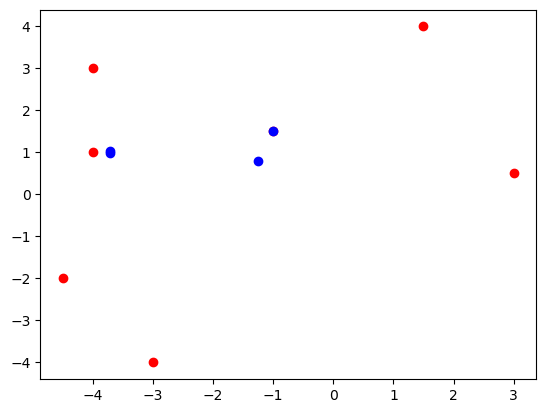

In [25]:
fig,ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],c = 'r')
ax.scatter(kverts[:,0],kverts[:,1],c ='b')

In [28]:
print(min(X[:,0]))
      

-4.5


C:\Users\85chr\AppData\Local\Temp\ipykernel_45448\2991616393.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
C:\Users\85chr\AppData\Local\Temp\ipykernel_45448\1976004132.py:72: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
C:\Users\85chr\AppData\Local\Temp\ipykernel_45448\2991616393.py:239: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if safeX == 

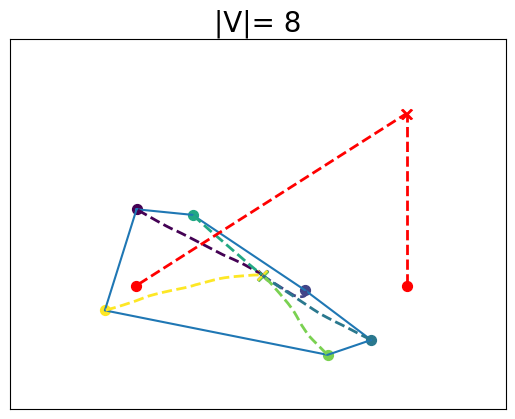

In [77]:
fig, ax = plt.subplots()
#fig2,ax2 = plt.subplots()

n = 8
offset = np.ones((n,2))*.5;
X= 10*(np.random.rand(n,2)-offset)
#X = np.array([(-3,-1), (-3, 4),(0.5 ,-4),(1.5,6),(3.5,2),(4,-1)]);
#X[n-1]= np.array((5,1))
attackers = [n-1]
if n >6:
    X[n-2] = np.array((6,-1))
    attackers = [n-2,n-1]
if n>9:
    X[n-3] = np.array((7,-3))
    attackers = [n-3,n-2,n-1];

Xn = np.zeros((n,6,2));
#Xn = np.zeros((8,8,2))
N = []
for i in range(n):
    retry = True
    while retry:
        q = 0
        nh = random.sample(range(8),6)
        for attacker in attackers:
            if attacker in nh:
                q= q+1
        if q<2:
            N.append(nh)
            Xn[i][:] = X[N[i]]
            retry = False

   
f = len(attackers);
#imp = .5*np.ones((6,6))-.5*np.eye(6);
imp = 0.5;
colors= get_colors(n,f);
empty = False;


frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:n-f]);
xplot = [];
yplot = [];
ham = 0;
attackerTarget = [np.array((6,6)),np.array((6,6))]
Bx = getPotRegions(X,imp);
imprecision = False
if imprecision:
    for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
                #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
imp = 0
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
for i in range(n-f):
    lbl = r'$v_{s1}$'.replace('s1',str(i+1));
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);

for idx in attackers:
    lbl = r'$v_f$'#+str(attackers.index(idx)+1);
    ax.scatter(X[idx,0],X[idx,1],c= colors[idx], marker = 'o',label = lbl,s = 50);
maxdist = np.zeros((1,602))
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
snapshot= (0,80,160,240,300,600)
imphist = [];
tm = []
while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;

    for i in range(n):
        if i not in attackers:
                    Xn[i][:] = X[N[i]]#X+np.matlib.repmat(a,6,1);
        if i not in attackers:
            #safeX,safeY = CPIH_Safepoint(n,Bx,i);
            try:
                safeX,safeY = getCenterpoint(6,Xn[i],i);
                #print("agent",i," has safepoint:",np.mean(safeX),", ",np.mean(safeY))
            except:
                safeX,safeY = [0,0]
                #print("no Safepoints")
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)) or safeX.size ==0:
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = X[i]
            else:
                target[i] = [np.mean(safeX), np.mean(safeY)];

                    
               # emptyCPIH[i] =1;
            
        elif i in attackers:
            target[i] = attackerTarget[attackers.index(i)];
       
                
        

    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i]);

    Xhist.append(X.copy());

    
    
    if step>600:
        empty = True;

  
    for i in range(n-len(attackers)):
        for j in range(n-len(attackers)):
            temp = np.linalg.norm(X[i]-X[j]);
            if temp> maxdist[0][step]:
                maxdist[0][step] = temp;
    step +=1;

for i in range(n):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-6,9);
ax.set_ylim(-6,9);
ax.set_xticks([])
ax.set_yticks([])
plt.title('|V|= '+str(n),fontsize = 20);
plt.savefig("Centerpoint_trajectories_n"+str(n)+"_f"+str(f)+".jpg")

In [78]:
TM = []
for i in range(len(X)):
    TM.append([])
    for x in Xhist:
        TM[i].append(TukeyMedian(x[N[i]]))


In [79]:
print(np.arange(5))

[0 1 2 3 4]


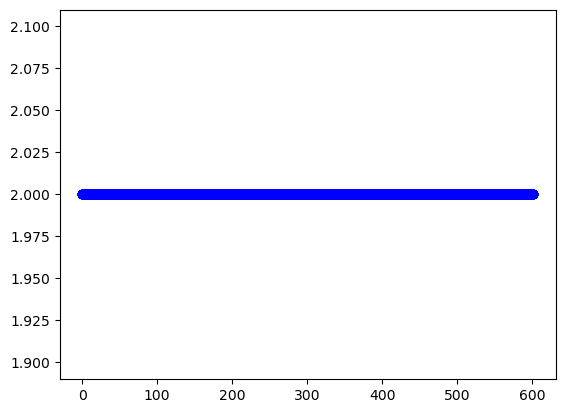

In [81]:
fig, ax = plt.subplots()
x = np.arange(len(Xhist))
for i in range(len(X)):
    ax.scatter(x,TM[i], c='b')


In [32]:
print(Xhist[100])

[[-0.61125405  0.20742063]
 [ 1.62091473 -1.0917739 ]
 [ 0.20750552 -1.33261353]
 [-1.1888243  -0.65535983]
 [-0.96742404  1.19308751]
 [ 2.08878463  0.3749597 ]
 [ 6.          3.46339587]
 [ 3.23913878  2.25015477]]
